<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [102]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [103]:
!ls

capstone_user_identification
week1_prepare_dataset.ipynb
week2_analysis_hypotheses.ipynb
week3_visual_analysis_and_fe.ipynb


In [104]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [105]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                              session_length=10, window_size=10):

    files_list = glob(path_to_csv_files+'\*')
    files_list.sort()

    # Инициируем частотный словарь уникальных сайтов вида {'site_string': (site_id, site_freq)}
    site_dict = {}
    idx_dict = {}

    # Создаем счетчик файлов/юзеров
    n = 0

    # Создаем пустой массив для наполнения данными по сайтам и времени их посещения
    data_sites = np.empty((0, session_length))
    data_times = np.empty((0, session_length))

    # Создаем пустой массив для наполнения user_id
    target = []

    # Проходим по файлам
    for file_name in tqdm_notebook(files_list):

        s = file_name
        start = s.find(r'\user')+5
        end = s.find('.')
        n = int(s[start:end])

        # открываем текущий файл и загружаем сайты
        sites = pd.read_csv(file_name).values[:, 1]
        times = pd.read_csv(file_name).values[:, 0]  # загружаем тайм-стемпы

        # Наполняем частотный словарь:
        for site in sites:
            if site in site_dict:
                site_dict[site] += 1
            else:
                site_dict[site] = 1

        # Формируем массив исходя из session_length и window_size:
        ar_sites = []
        ar_times = []

        for i in range(0, len(sites), window_size):
            tmp = sites[i:(i+session_length)]
            tmp2 = times[i:(i+session_length)]
            if len(tmp) < session_length:
                tmp = np.append(tmp, [0]*(session_length-len(tmp)))
                tmp2 = np.append(tmp2, [np.nan]*(session_length-len(tmp2)))
            ar_sites = np.append(ar_sites, tmp)
            ar_times = np.append(ar_times, tmp2)

        # Меняем форму array на session_length столбцов:
        ar_sites.resize(len(ar_sites)//session_length, session_length)
        ar_times.resize(len(ar_times)//session_length, session_length)

        # Добавляем колонку с user_id:
        user_id = np.asarray([n]*len(ar_sites))

        target = np.append(target, user_id)

        data_sites = np.vstack((data_sites, ar_sites))
        data_times = np.vstack((data_times, ar_times))

    # Преобразуем массивы с сайтами и временем их посещения в дата фреймы:
    data_sites = pd.DataFrame(data_sites)
    data_times = pd.DataFrame(data_times)

    # Загружаем словарь из pickle файла:
    with open(site_freq_path, 'rb') as pickle_file:
        freq = pickle.load(pickle_file)

    # Мэпим id сайтов из словаря к фрейму с наименованиями сайтов:
    freq[0] = (0, 0)
    freq = {k: v[0] for k, v in freq.items()}

    for column in range(session_length):
        data_sites[column] = data_sites[column].map(freq)

    # Преобразуем тайм-стемпы в формат даты и заполняем пропущенные значения:
    data_times = data_times.apply(
        pd.to_datetime).fillna(method='ffill', axis=1)

    # Создаем дата фрейм с time_diff:
    time_diff = pd.DataFrame(index=data_times.index)

    for i in range(1, session_length):
        time_diff[i] = (data_times[i] - data_times[i-1]
                        ).astype('timedelta64[s]').astype(int)

    time_diff[session_length] = (
        data_times[session_length-1] - data_times[0]).astype('timedelta64[s]').astype(int)

    # Создаем признак #unique_sites:
    num_unique_sites = [np.unique(data_sites.values[i, :][data_sites.values[i, :] != 0]).shape[0]
                        for i in range(data_sites.shape[0])]

    # Создаем признаки start_hour и day_of_week:
    time_feats = np.column_stack((data_times[0].apply(
        lambda ts: ts.hour), data_times[0].apply(lambda ts: ts.weekday())))

    num_time_target = pd.DataFrame(np.column_stack(
        (num_unique_sites, time_feats, target)).astype(int))

    data = pd.DataFrame(
        pd.concat([data_sites, time_diff, num_time_target], axis=1, ignore_index=True))

    data.columns = feature_names

    return data

**Проверим функцию на игрушечном примере.**

In [106]:
feature_names = ['site' + str(i) for i in range(1, 11)] + \
                ['time_diff' + str(j) for j in range(1, 10)] + \
                ['session_timespan', '#unique_sites', 'start_hour',
                 'day_of_week', 'user_id']

train_data_toy = prepare_train_set_with_fe(os.path.join(
    PATH_TO_DATA, '3users'), site_freq_path=os.path.join(
    PATH_TO_DATA,'site_freq_3users.pkl'), feature_names=feature_names, session_length=10)

In [107]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,3,2,2,7,2,1,8,5,9,10,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,3,1,1,1,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,3,2,6,6,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,4,1,2,1,2,1,1,5,11,4,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,4,1,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [108]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)


Wall time: 2.36 s


In [109]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [110]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(
    PATH_TO_DATA, '150users'), site_freq_path=os.path.join(
    PATH_TO_DATA, 'site_freq_150users.pkl'), feature_names=feature_names, session_length=10)


Wall time: 25.5 s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [111]:
new_features_10users = train_data_10users[[
    'session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[[
    'session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [112]:
with open(os.path.join(
        PATH_TO_DATA, 'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)

with open(os.path.join(
        PATH_TO_DATA, 'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [113]:
np.median(new_features_10users['session_timespan'])

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [114]:
np.median(new_features_10users['day_of_week'])

2.0

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [115]:
np.median(new_features_150users['start_hour'])

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [116]:
np.median(new_features_150users['#unique_sites'])

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [117]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
                33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}

train_data_10users['user_id'] = train_data_10users['user_id'].map(id_name_dict)

In [118]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,user_id
0,192,574,133,3,133,133,3,133,203,133,10,0,0,1,20,1,0,1,0,33,5,8,4,John
1,415,193,674,254,133,31,393,3305,217,55,1,0,163,105,0,1,3,3,8,284,10,8,4,John
2,55,3,55,55,5,293,415,333,897,55,0,14,1,242,0,0,1,0,0,258,7,8,4,John
3,473,3306,473,55,55,55,55,937,199,123,2,1,0,1,25,1,0,0,0,30,6,8,4,John
4,342,55,5,3307,258,211,3308,2086,675,2086,1,0,1,1,1,0,1,1,0,6,9,8,4,John


In [119]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey': 'blueviolet',
             'Naomi': 'hotpink', 'Avril': 'orchid',
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen',
             'Dick': 'slategrey', 'Ed': 'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

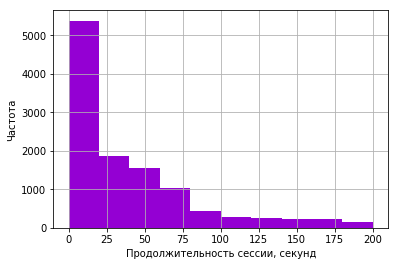

In [120]:
train_data_10users['session_timespan'][train_data_10users['session_timespan']<=200].hist(color='darkviolet');
plt.xlabel('Продолжительность сессии, секунд')
plt.ylabel('Частота')
plt.grid(True)

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

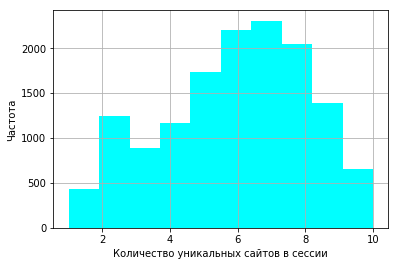

In [121]:
train_data_10users['#unique_sites'].hist(color='aqua');
plt.ylabel('Частота');
plt.xlabel('Количество уникальных сайтов в сессии');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

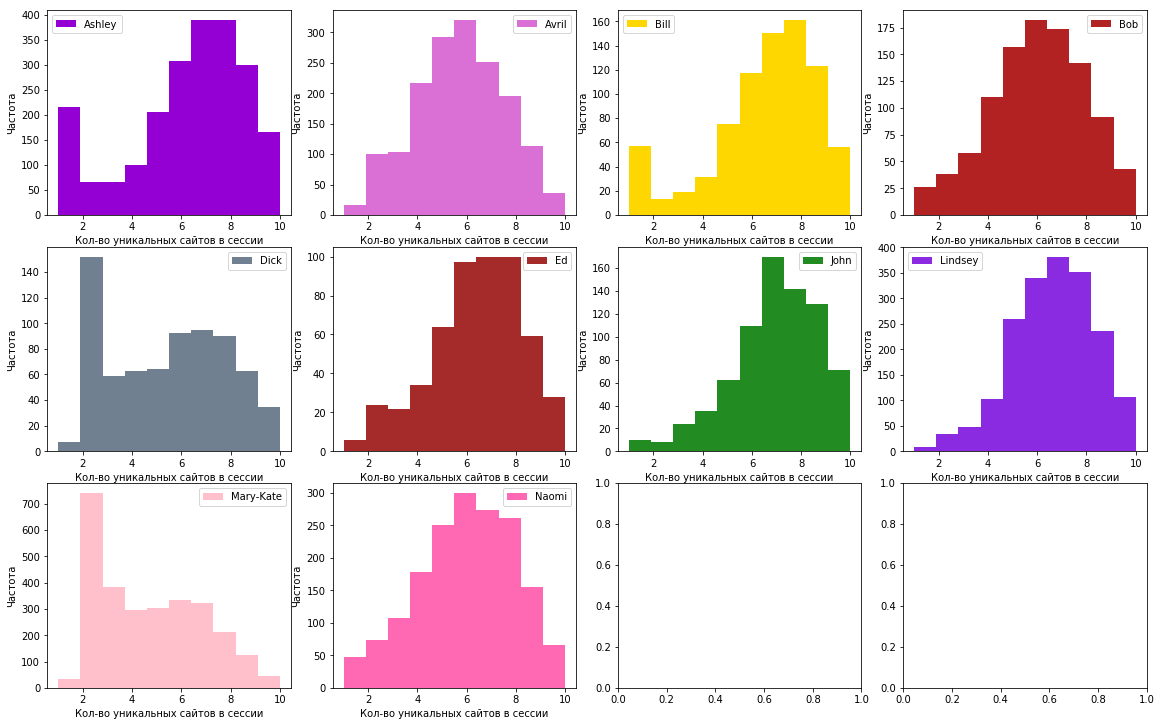

In [122]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

fig.tight_layout()

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('user_id')):
    plot = axes.flatten()[idx]
    plot.hist(sub_df['#unique_sites'], color=color_dic[user], label=user)
    plot.set_xlabel('Кол-во уникальных сайтов в сессии')
    plot.set_ylabel('Частота')
    plot.legend()

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

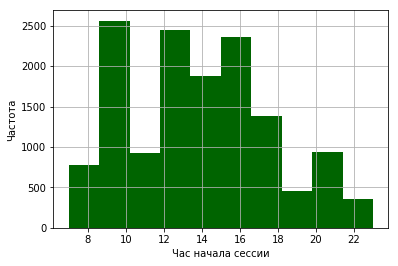

In [123]:
train_data_10users['start_hour'].hist(color='darkgreen')
plt.ylabel('Частота');
plt.xlabel('Час начала сессии');


**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

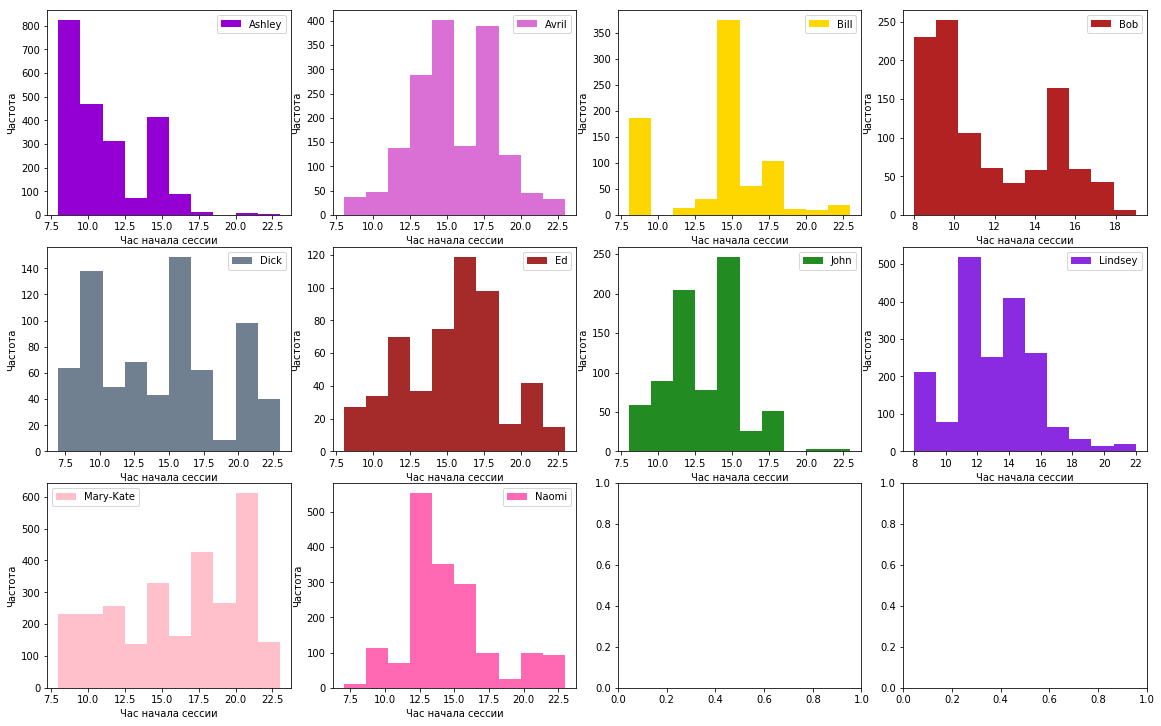

In [124]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

fig.tight_layout()

# как вариант, можно и по-другому
for idx, (user, sub_df) in enumerate(train_data_10users.groupby('user_id')):
    plot = axes.flatten()[idx]
    plot.hist(sub_df['start_hour'], color=color_dic[user], label=user)
    plot.set_xlabel('Час начала сессии')
    plot.set_ylabel('Частота')
    plot.legend()

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

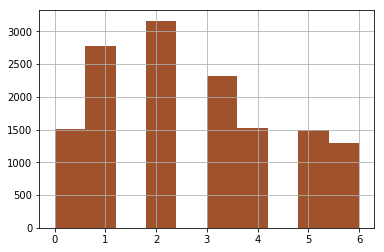

In [125]:
train_data_10users['day_of_week'].hist(color='sienna');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

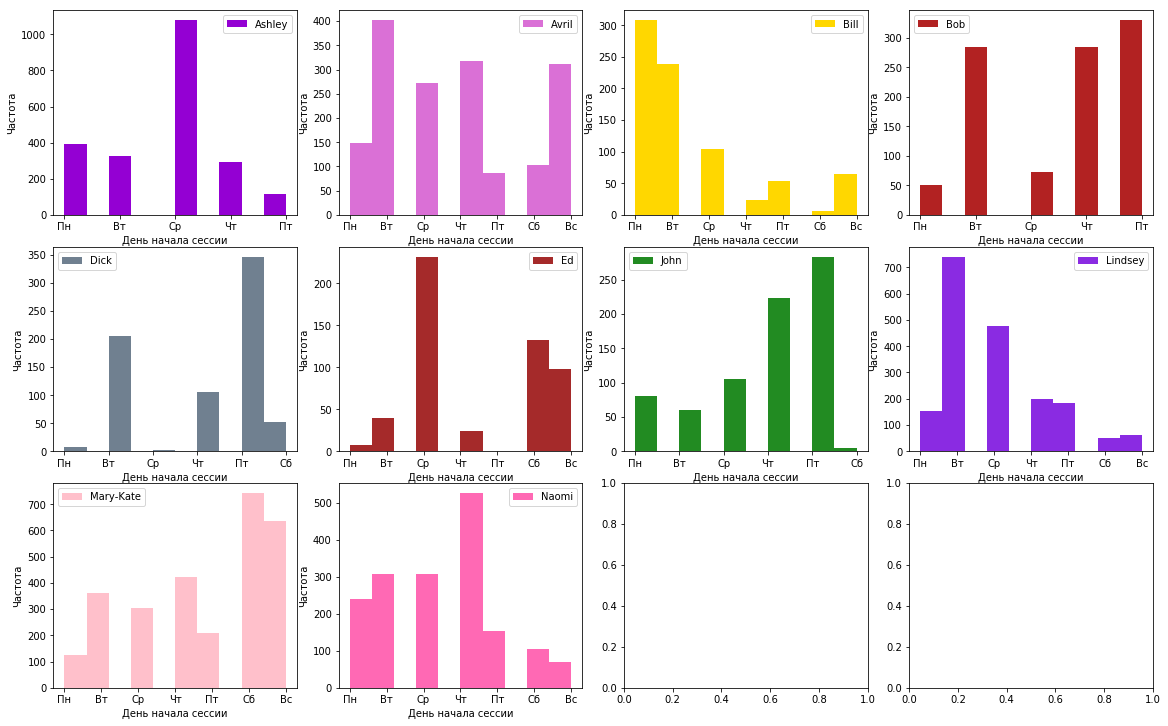

In [126]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

fig.tight_layout()

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(train_data_10users.groupby('user_id')): 
    plot = axes.flatten()[idx]
    plot.hist(sub_df['day_of_week'], color=color_dic[user], label=user)
    plot.set_xlabel('День начала сессии')
    plot.set_ylabel('Частота')
    plot.set_xticklabels([0,'Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    plot.legend()

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

1. Ashley <br>
Заходит в интернет в рабочие дни с пиком в среду, преимущественно в первой половине дня с еще одним пиком в районе 15 часов. Часто имееет один уникальный сайт в сессии.

2. Avril <br>
Заходит в интернет в течение всей недели и на протяжении всего дня. В среднем имеет 6 уникальных сайтов в сессии.

3. Bill <br>
Заходит в интернет в течение всей недели с пиком в понедельник-вторник. Два пика времени начала сесии - 9 утра и 3 часа дня. Часто имеет один уникальный сайт в сесии.

4. Bob <br>
Заходит в интернет в течение всей недели, преимущественно в первой половине дня. В среднем имеет 6 уникальных сайтов в сессии.

5. Dick <br>
Заходит в интернет преимущественно во вторник, четверг, пятницу и субботу. Начало сессии в течение рабочего дня или с 20 до 22 часов. Часто имеет 2 уникальных сайта в сессии.

6. Ed <br>
Заходит в интернет преимущественно в среду, субботу и воскресенье; без посещений по пятницам. Преимущественно во второй половине дня. Среднее количество уникальных сайтов в сессии - 7.

7. John <br>
Заходит в интернет в течение рабочей недели и в рабочее время с наростающим количеством сессий от понедельника к пятнице. Имеет в среднем 7 уникальных сайтов в сессии.

8. Lindsey <br>
Заходит в интернет в течение всей недели с пиком во вторник и среду. Основные часы посещений с 11 до 16:00. Среднее количество уникальных сайтов в сессии - 7.

9. Mary-Kate <br>
Заходит в интернет в течение всей недели с пиком на выходные дни. Время сессиий распределено в течение дня. Часто имеет 2 уникальных сайта в сессии.

10. Naomi <br>
Заходит в интернет в течение всей недели с пиком в четверг, преимущественно с 12 до 16:00. В среднем имеет 6 уникальных сайтов в сессии.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [127]:
with open(PATH_TO_DATA +r'/site_freq_10users.pkl', 'rb') as pickle_file:
        freq = pickle.load(pickle_file)

In [128]:
[freq[k][1] for (k,v) in sorted(freq.items(), key=lambda t: t[1], reverse=False)[:10]]

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [129]:
top10_freqs = [freq[k][1] for (k,v) in sorted(freq.items(), key=lambda t: t[1], reverse=False)[:10]]
top10_sites = [k for (k,v) in list(sorted(freq.items(), key=lambda t: t[1], reverse=False)[:10])]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

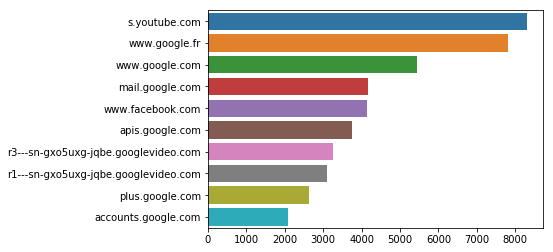

In [130]:
sns.barplot(top10_freqs, top10_sites);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [131]:
def feature_engineering(path_to_csv_files, site_freq_path, features, session_length=10):
    files_list = glob(path_to_csv_files+'/*')
    files_list.sort()
    window_size = 10

    # Инициируем частотный словарь уникальных сайтов вида {'site_string': (site_id, site_freq)}
    site_dict = {}
    idx_dict = {}

    # Создаем счетчик файлов/юзеров
    n = 0
    
    # Создаем пустой массив для наполнения данными по сайтам и времени их посещения
    data_sites = np.empty((0, session_length))
    data_times = np.empty((0, session_length))
    
    # Создаем пустой массив для наполнения user_id
    target = []
    
    # Проходим по файлам
    for file_name in tqdm_notebook(files_list):
        
        s = file_name
        start = s.find(r'\user')+5
        end = s.find('.')
        n = int(s[start:end])
        
        sites = pd.read_csv(file_name).values[:, 1] #открываем текущий файл и загружаем сайты
        times = pd.read_csv(file_name).values[:, 0] #загружаем тайм-стемпы
         
        # Наполняем частотный словарь:
        for site in sites:
            if site in site_dict:
                site_dict[site] += 1
            else:
                site_dict[site] = 1
                        
        # Формируем массив исходя из session_length и window_size:
        ar_sites = []
        ar_times = []
        
        for i in range(0, len(sites), window_size):
            tmp = sites[i:(i+session_length)]
            tmp2 = times[i:(i+session_length)]
            if len(tmp) < session_length:
                tmp = np.append(tmp, [0]*(session_length-len(tmp)))
                tmp2 = np.append(tmp2, [np.nan]*(session_length-len(tmp2)))
            ar_sites = np.append(ar_sites, tmp)
            ar_times = np.append(ar_times, tmp2)
        
        # Меняем форму array на session_length столбцов:
        ar_sites.resize(len(ar_sites)//session_length, session_length)
        ar_times.resize(len(ar_times)//session_length, session_length)
        
        # Добавляем колонку с user_id:
        user_id = np.asarray([n]*len(ar_sites))
        
        target = np.append(target, user_id)
   
        data_sites = np.vstack((data_sites, ar_sites))
        data_times = np.vstack((data_times, ar_times))
    
    # Преобразуем массивы с сайтами и временем их посещения в дата фреймы:
    data_sites = pd.DataFrame(data_sites)
    data_times = pd.DataFrame(data_times)
    
    # Загружаем словарь из pickle файла:
    with open(site_freq_path, 'rb') as pickle_file:
        freq = pickle.load(pickle_file)
    
    # Мэпим id сайтов из словаря к фрейму с наименованиями сайтов:
    freq[0]=(0,0)
    freq = {k: v[0] for k, v in freq.items()}
    
    for column in range(session_length):
        data_sites[column] = data_sites[column].map(freq)
    
    
    # Преобразуем тайм-стемпы в формат даты и заполняем пропущенные значения:
    data_times = data_times.apply(pd.to_datetime).fillna(method='ffill', axis=1)
    
    
    # Создаем дата фрейм с time_diff:
    time_diff = pd.DataFrame(index = data_times.index)
    
    for i in range(1, session_length):
        time_diff[i] = (data_times[i] - data_times[i-1]).astype('timedelta64[s]').astype(int)
    
    time_diff[session_length] = (data_times[session_length-1] - data_times[0]).astype('timedelta64[s]').astype(int)
    
    
    # Создаем признак #unique_sites:
    num_unique_sites = [np.unique(data_sites.values[i, :][data_sites.values[i, :]!=0]).shape[0] 
                    for i in range(data_sites.shape[0])]
    
    
    # Создаем признаки start_hour и day_of_week:
    time_feats = np.column_stack((data_times[0].apply(lambda ts: ts.hour), #hour
                                  data_times[0].apply(lambda ts: ts.weekday()), #weekday
                                  data_times[0].apply(lambda ts: ts.year), #year
                                  data_times[0].apply(lambda ts: ts.month), #month
                                  data_times[0].apply(lambda ts: ts.year * 100 + ts.month))) #year_month
    
    
    
    num_time_target = pd.DataFrame(np.column_stack((num_unique_sites, time_feats, target)).astype(int))
    
    data = pd.DataFrame(pd.concat([data_sites, time_diff, num_time_target], axis=1, ignore_index=True))
    
    feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'year', 'month', 'year_month', 'user_id']
            
    data.columns = feature_names
    
    return data[features]

In [132]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'), features = ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'year', 'month', 'year_month'])


Wall time: 2.51 s


In [133]:
new_features_10users.head()

,session_timespan,#unique_sites,start_hour,day_of_week,year,month,year_month
0,33,5,8,4,2013,11,201311
1,284,10,8,4,2013,11,201311
2,258,7,8,4,2013,11,201311
3,30,6,8,4,2013,11,201311
4,6,9,8,4,2013,11,201311


In [134]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'), features = ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'year', 'month', 'year_month'])


Wall time: 27 s


**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [135]:
list(enumerate(new_features_150users.columns))

[(0, 'session_timespan'),
 (1, '#unique_sites'),
 (2, 'start_hour'),
 (3, 'day_of_week'),
 (4, 'year'),
 (5, 'month'),
 (6, 'year_month')]

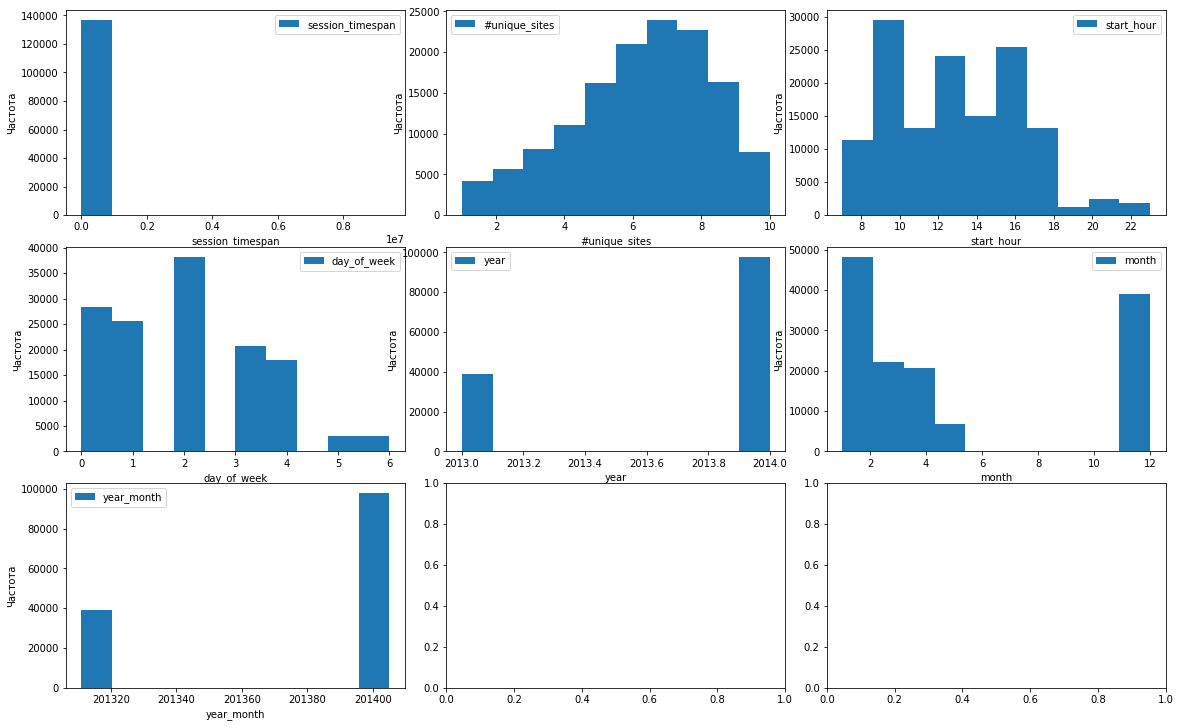

In [136]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 10))

fig.tight_layout()

for idx, feature in  enumerate(new_features_150users.columns): 
    plot = axes.flatten()[idx]
    plot.hist(new_features_150users[feature], label=feature)
    plot.set_xlabel(str(feature))
    plot.set_ylabel('Частота')
    plot.legend()


**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [137]:
%%time

selected_features_10users = feature_engineering(
    os.path.join(PATH_TO_DATA,'10users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'), 
    features = ['session_timespan', '#unique_sites', 'start_hour',
                'day_of_week', 'year', 'month', 'year_month'])

selected_features_150users = feature_engineering(
    os.path.join(PATH_TO_DATA, '150users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'), 
    features = ['session_timespan', '#unique_sites', 'start_hour',
                'day_of_week', 'year', 'month', 'year_month'])


Wall time: 28.6 s


In [138]:
with open(os.path.join(
    PATH_TO_DATA, 'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, 
                selected_features_10users_pkl, 
                protocol=2)

with open(os.path.join(
    PATH_TO_DATA, 'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, 
                selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 